## Causal Inference Project - Email Marketing

###  1. Backgroud: 

Email Marketing is a key strategy for driving customer engagement and sales. However, traditional conversion rate analysis fails to measure the true causal impact of email campaigns. This project applied causal inference and uplift modeling to identify customer groups who are positively influenced by email promotions, optimizing marketing spend and increasing ROI.

### 2. Initialization: 

In [1]:
import xgboost, sklearn
from xgboost import XGBClassifier
print("xgboost:", xgboost.__version__, "| sklearn:", sklearn.__version__)

xgboost: 2.0.3 | sklearn: 1.7.2


In [2]:
# Import package
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, log_loss, roc_curve, auc
import optuna  
from sklift.datasets import fetch_hillstrom
import statsmodels.api as sm


/Users/bybzfanyanru/anaconda3/envs/bayesenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import warnings
import os
from sklearn.exceptions import FitFailedWarning


warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FitFailedWarning)

# Close Optuna trial logging
optuna.logging.set_verbosity(optuna.logging.ERROR)

warnings.filterwarnings("ignore")
np.seterr(all="ignore")
os.environ["PYTHONWARNINGS"] = "ignore"

In [4]:
# Load Hillstorm dataset
def load_hillstorm(target, print_info=True):
    dataset = fetch_hillstrom(target_col=target)
    df = dataset.data
    df['segment'] = dataset.treatment # three segment: choose one for treatment
    df[target] = dataset.target  # three target feature: choose one for target 

    if print_info:
        print("Show me the top of the dataset\n")
        print(df.head())
        print("\n\n\n")
        print("Are there null value in this dataframe?\n")
        print(df.isna().sum())
        print("\n\n\n")
        print("What does the dataframe look like? What datatype are the features\n")
        print(df.info())
        print("\n\n\n")
        print(df.columns)
    
    return df

data = load_hillstorm(target='visit')
df = data.copy()

Show me the top of the dataset

   recency history_segment  history  mens  womens   zip_code  newbie channel  \
0       10  2) $100 - $200   142.44     1       0  Surburban       0   Phone   
1        6  3) $200 - $350   329.08     1       1      Rural       1     Web   
2        7  2) $100 - $200   180.65     0       1  Surburban       1     Web   
3        9  5) $500 - $750   675.83     1       0      Rural       1     Web   
4        2    1) $0 - $100    45.34     1       0      Urban       0     Web   

         segment  visit  
0  Womens E-Mail      0  
1      No E-Mail      0  
2  Womens E-Mail      0  
3    Mens E-Mail      0  
4  Womens E-Mail      0  




Are there null value in this dataframe?

recency            0
history_segment    0
history            0
mens               0
womens             0
zip_code           0
newbie             0
channel            0
segment            0
visit              0
dtype: int64




What does the dataframe look like? What datatype are the fe

The Hillstorm dataset includes three segments: Women's Email, Men's Email, and No Email. To define a treatment feature, we can select two of these segments for comparison.

The Hillstorm dataset also includes three target features: visit (user whether visit webstite or not), conversion (user whether purchase or not), and spend (user purchase amount)

### 3. Data and data processing

The Hillstrom dataset contains 64,000 observations and 12 variables, including 3 target features (Visit, Conversion, and Spend) and 1 treatment feature (Segment). The remaining 8 features can be used as independent variables in our model to predict customer behavior.

In [5]:
df.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,Womens E-Mail,0
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0
2,7,2) $100 - $200,180.65,0,1,Surburban,1,Web,Womens E-Mail,0
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0
4,2,1) $0 - $100,45.34,1,0,Urban,0,Web,Womens E-Mail,0


#### Independent varaible for modeling

The following feature will be included in our model as predictors:
- **Recency**: The number of months since the customer's last purchase.
- **History_segment**: A categorical variable that segment customers based on their historical spending range.
- **History**: The total dollar amount spent by the customer in the past year.
- **Mens**: A binary indicator (`1/0`), where `1` means the customer has purchased men's products in the past year.
- **Womens**: A binary indicator (`1/0`), where `1` means the customer has purchased women's products in the past year.
- **Zip_code**: A categorical variable classifying customer's location into Urban, Rural and Surburban.
- **Newbie**: A binary indicator (`1/0`), where `1` means the customer is new (join within 12 months).
- **Channel**: The channel through which customer made past purchase (e.g. Phone, Web)

#### Target features

 **Target Features (Visit, Conversion, Spend)**: These variables represent customer responses to email campaigns and will be used as dependent variables in the model.

- **Visit**: A binary indicator (`1/0 `), where 1 means customer visited the website within two weeks after sending email.
- **Conversion**: A binary indicator (`1/0`), where 1 means customer purchased products within two weeks after sending email.
- **Spend**: The total amount spent wihtin two weeks after sending email.

#### Treatment feature

- **Segment**: The variable describes the experiment group (Men's Email, Women's Email and No Email) and is used for causal inference rather than as an independent predictor.

#### Feature Engineering

In [6]:
# Create a treament variable from Men's Email, Experiment:1 / Control: 0
df = df.loc[df['segment'].isin(['Mens E-Mail', 'No E-Mail'])]
df['treatment'] = df['segment'].map({'Mens E-Mail': 1, 'No E-Mail': 0})
df['treatment'].value_counts(normalize=True)

# Visit as target variable
df['target'] = df['visit'].copy()
df['target'].value_counts()

# Create categorical variable: history_bins
conditions = [
    df['history_segment'].isin(['1) $0 - $100', '2) $100 - $200']),
    df['history_segment'].isin(['3) $200 - $350', '4) $350 - $500', '5) $500 - $750'])
]

choices = ['low', 'medium']
df['history_bins'] = np.select(conditions, choices, default='high')
df['history_bins'].value_counts()

# One-hot encoding
df = pd.get_dummies(df, columns=['zip_code'], drop_first=True, dtype=int) # Encode zip code
df = pd.get_dummies(df, columns=['channel'], drop_first=True, dtype=int) # Encode channel
df['recency_bins'] = \
    np.where(df['recency'].between(1,4), 'low', np.where(df['recency'].between(5,8), 'medium', 'high')) # Recency bin
df = pd.get_dummies(df, columns=['recency_bins'], drop_first=True, dtype=int)
df = pd.get_dummies(df, columns=['history_bins'], drop_first=True, dtype=int)
df = df.drop(columns=['segment','visit','history','recency','history_segment'])
df = df.rename(columns={'history_segment_2) $100 - $200':'history_segment_100_200',
                        'history_segment_3) $200 - $350':'history_segment_200_350',
                        'history_segment_4) $350 - $500':'history_segment_350_500',
                        'history_segment_5) $500 - $750':'history_segment_500_750',
                        'history_segment_6) $750 - $1,000':'history_segment_750_1000',
                        'history_segment_7) $1,000 +':'history_segment_1000_plus'})

# Experiment group and control group: see feature difference
df.groupby('treatment').mean()

,mens,womens,newbie,target,zip_code_Surburban,zip_code_Urban,channel_Phone,channel_Web,recency_bins_low,recency_bins_medium,history_bins_low,history_bins_medium
treatment,,,,,,,,,,,,
0,0.553224,0.547639,0.501971,0.106167,0.451751,0.400920,0.437764,0.439923,0.429879,0.263682,0.584249,0.367033
1,0.550946,0.551415,0.501525,0.182757,0.445910,0.401887,0.433660,0.445394,0.429624,0.256817,0.582672,0.365326


Treatment group visit rate significantly higher than control group.

### 4. Men's Email vs Women's Email

Which email campaign was more effective, the men's email or the women's email?

In [7]:
data.groupby('segment')['visit'].value_counts().rename('visit_count').reset_index()

,segment,visit,visit_count
0,Mens E-Mail,0,17413
1,Mens E-Mail,1,3894
2,No E-Mail,0,19044
3,No E-Mail,1,2262
4,Womens E-Mail,0,18149
5,Womens E-Mail,1,3238


In [8]:
mens = data.loc[data['segment'] == 'Mens E-Mail']['visit'].mean()
womens = data.loc[data['segment'] == 'Womens E-Mail']['visit'].mean()
no_email = data.loc[data['segment'] == 'No E-Mail']['visit'].mean()

mens_lift = (mens - no_email) / no_email
womens_lift = (womens - no_email) / no_email
print(f"Men's email lift: {mens_lift*100}")
print(f"Women's email lift: {womens_lift*100}")

Men's email lift: 72.1404616781399
Women's email lift: 42.60550702669102


#### Plot (Visit / Lift / Conversion / Lift)

##### Visit

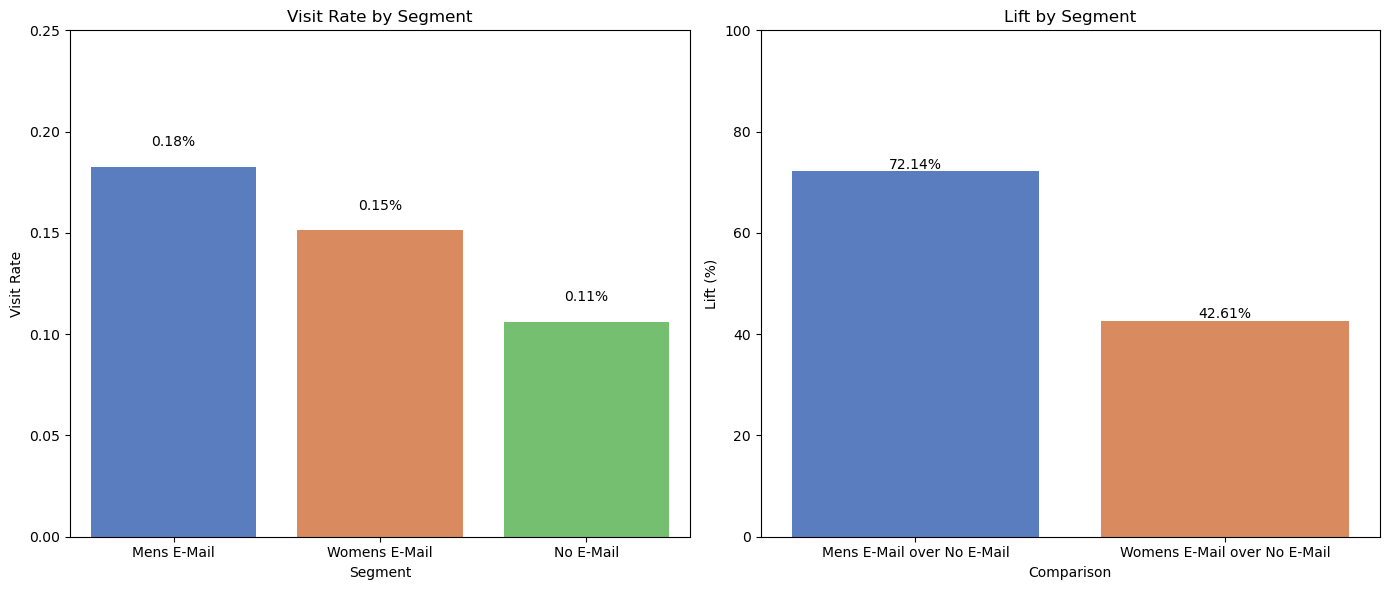

In [9]:
# Plot visit rate (P1)
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
visit_rates = pd.DataFrame({
    'Segment': ['Mens E-Mail', 'Womens E-Mail', 'No E-Mail'],
    'Visit Rate': [mens, womens, no_email]
})
sns.barplot(x='Segment', y='Visit Rate', data=visit_rates, palette='muted', hue='Segment')
for index, value in enumerate(visit_rates['Visit Rate']):
    plt.text(index, value + 0.01, f'{value:.2f}%', ha='center')
plt.xlabel('Segment')
plt.ylabel('Visit Rate')
plt.title('Visit Rate by Segment')
plt.ylim(0,0.25)

# Plot visit rate lift (P2)
plt.subplot(1,2,2)
lifts = pd.DataFrame({
    'Comparison': ['Mens E-Mail over No E-Mail', 'Womens E-Mail over No E-Mail'],
    'Lift (%)': [mens_lift*100, womens_lift*100]
})
sns.barplot(x='Comparison', y='Lift (%)', data=lifts, palette='muted', hue='Comparison')
for index, value in enumerate(lifts['Lift (%)']):
    plt.text(index, value + 0.5, f'{value:.2f}%', ha='center')
plt.xlabel('Comparison')
plt.ylabel('Lift (%)')
plt.title('Lift by Segment')
plt.ylim(0, 100)  

plt.tight_layout()
plt.show()

##### Conversion

In [10]:
data = load_hillstorm(target='conversion', print_info=False)
mens = data.loc[data['segment'] == 'Mens E-Mail']['conversion'].mean()
womens = data.loc[data['segment'] == 'Womens E-Mail']['conversion'].mean()
no_email = data.loc[data['segment'] == 'No E-Mail']['conversion'].mean()

mens_lift = (mens - no_email) / no_email
womens_lift = (womens - no_email) / no_email

print(f"Men's Email Lift: {mens_lift*100}")
print(f"Women's Email Lift: {womens_lift*100}")


Men's Email Lift: 118.84218762863279
Women's Email Lift: 54.33130436982172


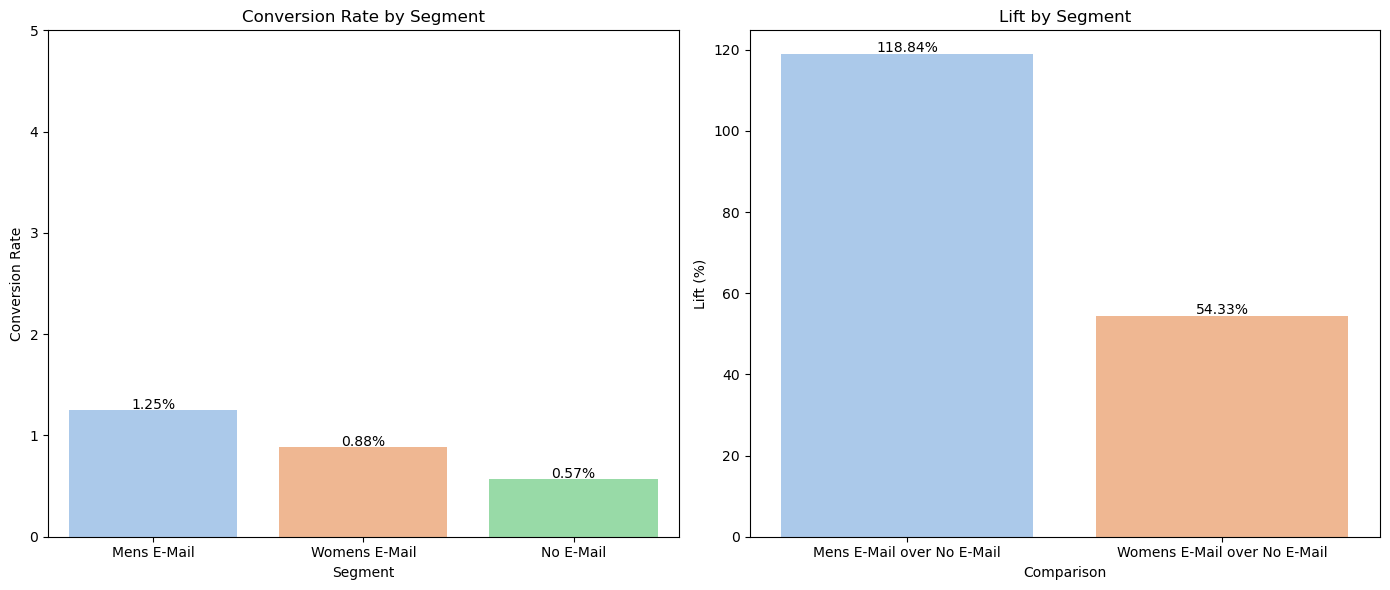

In [11]:
# Plot conversion rate (P3)
plt.figure(figsize=(14, 6))
plt.subplot(1,2,1)
conversion_rate = pd.DataFrame({
    'Segment': ['Mens E-Mail', 'Womens E-Mail', 'No E-Mail'],
    'Conversion Rate': [mens, womens, no_email]
})
conversion_rate['Conversion Rate'] = conversion_rate['Conversion Rate']*100
sns.barplot(x='Segment', y='Conversion Rate', data=conversion_rate, palette='pastel', hue='Segment')
for index, value in enumerate(conversion_rate['Conversion Rate']):
    plt.text(index, value + 0.01, f'{value:.2f}%', ha='center')
plt.xlabel('Segment')
plt.ylabel('Conversion Rate')
plt.title('Conversion Rate by Segment')
plt.ylim(0,5)

# Plot conversion rate lift (P4)
plt.subplot(1,2,2)
lifts = pd.DataFrame({
    'Comparison': ['Mens E-Mail over No E-Mail', 'Womens E-Mail over No E-Mail'],
    'Lift (%)': [mens_lift*100, womens_lift*100]
})
sns.barplot(x='Comparison', y='Lift (%)', data=lifts, palette='pastel', hue='Comparison')
for index, value in enumerate(lifts['Lift (%)']):
    plt.text(index, value + 0.5, f'{value:.2f}%', ha='center')
plt.xlabel('Comparison')
plt.ylabel('Lift (%)')
plt.title('Lift by Segment')

plt.tight_layout()
plt.show()

##### Spend

In [12]:
data = load_hillstorm(target='spend',print_info=False)
mens = data.loc[data['segment']=='Mens E-Mail']['spend'].mean()
womens = data.loc[data['segment']=='Womens E-Mail']['spend'].mean()
no_email = data.loc[data['segment']=='No E-Mail']['spend'].mean()

mens_lift = mens - no_email
womens_lift = womens - no_email

print(f"Men's email lift: ${mens_lift:.2f}")
print(f"Women's email lift: ${womens_lift:.2f}")

Men's email lift: $0.77
Women's email lift: $0.42


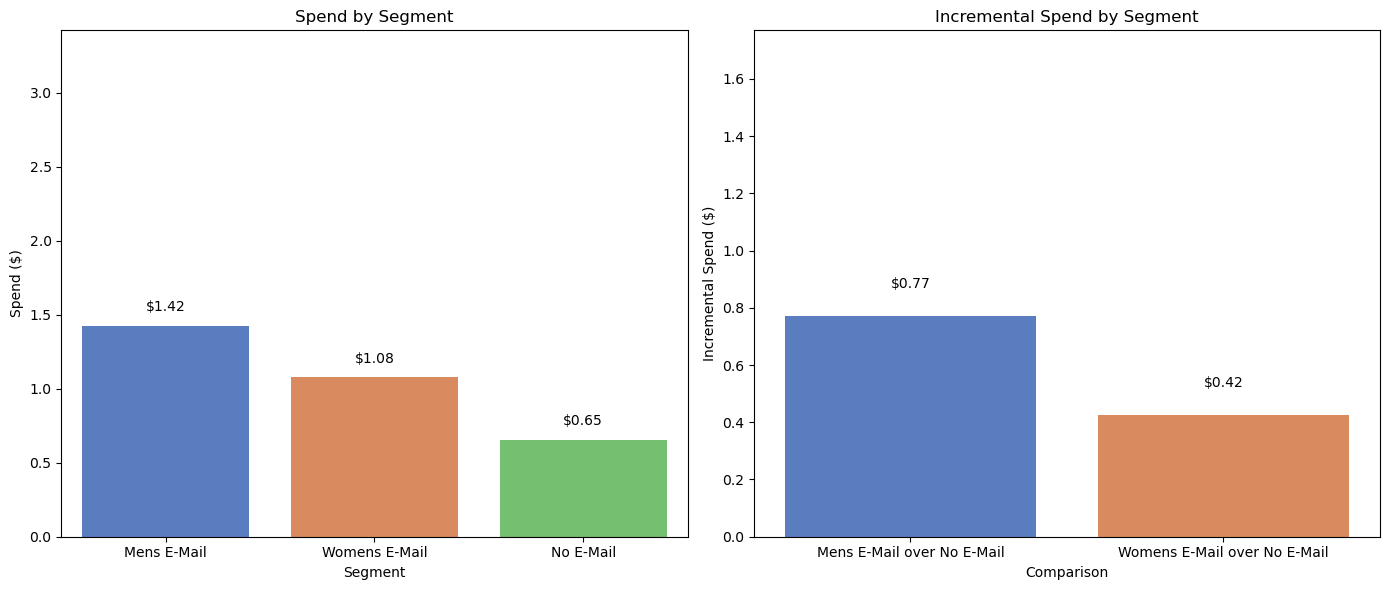

In [13]:
# Plot spend by segment (P1)
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
spend_rates = pd.DataFrame({
    'Segment': ['Mens E-Mail', 'Womens E-Mail', 'No E-Mail'],
    'Spend ($)': [mens, womens, no_email]
})
sns.barplot(x='Segment', y='Spend ($)', data=spend_rates, palette='muted', hue='Segment')
for index, value in enumerate(spend_rates['Spend ($)']):
    plt.text(index, value + 0.1, f'${value:.2f}', ha='center')
plt.xlabel('Segment')
plt.ylabel('Spend ($)')
plt.title('Spend by Segment')
plt.ylim(0, max(spend_rates['Spend ($)']) + 2)  

plt.subplot(1, 2, 2)
lifts = pd.DataFrame({
    'Comparison': ['Mens E-Mail over No E-Mail', 'Womens E-Mail over No E-Mail'],
    'Incremental Spend ($)': [mens_lift, womens_lift]
})
sns.barplot(x='Comparison', y='Incremental Spend ($)', data=lifts, palette='muted', hue='Comparison')
for index, value in enumerate(lifts['Incremental Spend ($)']):
    plt.text(index, value + 0.1, f'${value:.2f}', ha='center')
plt.xlabel('Comparison')
plt.ylabel('Incremental Spend ($)')
plt.title('Incremental Spend by Segment')
plt.ylim(0, max(lifts['Incremental Spend ($)']) + 1)  

plt.tight_layout()
plt.show()

Revenue average increment by Men's Email is $0.77, by Women's Email is $0.42.

### 5. Feature impact on Treatment Effect

Measure the impact of specific feature i on the target variable in both the Treatment and Control group.

Evaluate whether different features affect the uplift impact of the treatment on the target variable, in order to support marketing strategy optimization.

In [14]:
df.head()

,mens,womens,newbie,treatment,target,zip_code_Surburban,zip_code_Urban,channel_Phone,channel_Web,recency_bins_low,recency_bins_medium,history_bins_low,history_bins_medium
1,1,1,1,0,0,0,0,0,1,0,1,0,1
3,1,0,1,1,0,0,0,0,1,0,0,0,1
8,1,1,1,1,0,0,0,1,0,0,0,0,1
13,0,1,0,1,1,0,1,0,1,1,0,1,0
14,0,1,1,0,0,0,0,0,0,1,0,0,1


In [15]:
df.columns

Index(['mens', 'womens', 'newbie', 'treatment', 'target', 'zip_code_Surburban',
       'zip_code_Urban', 'channel_Phone', 'channel_Web', 'recency_bins_low',
       'recency_bins_medium', 'history_bins_low', 'history_bins_medium'],
      dtype='object')

In [16]:
data = df.groupby(['treatment', 'zip_code_Surburban']).agg({'target': 'mean'}).reset_index()

In [17]:
for i in df.columns.to_list(): # i represent ith feature
    if i not in ['treatment','target']:
        data = df.groupby(['treatment', i]).agg({'target': 'mean'}).reset_index()
        # fix feature (1): experiment group - control group
        diff_on = data.loc[(data['treatment']==1)&(data[i]==1)]['target'].values[0] - data.loc[(data['treatment']==0)&(data[i]==1)]['target'].values[0]
        # fix feature (0): experiment group - control group
        diff_off = data.loc[(data['treatment']==1)&(data[i]==0)]['target'].values[0] - data.loc[(data['treatment']==0)&(data[i]==0)]['target'].values[0]

        print(f"Feature {i} has a difference in means of {diff_on-diff_off:.2f}")
        print(f"Feature {i} has a treatment effect of {(diff_on-diff_off)/diff_off*100:.2f}%")
        print("="*100)



Feature mens has a difference in means of 0.01
Feature mens has a treatment effect of 15.57%
Feature womens has a difference in means of 0.01
Feature womens has a treatment effect of 19.38%
Feature newbie has a difference in means of -0.00
Feature newbie has a treatment effect of -3.25%
Feature zip_code_Surburban has a difference in means of -0.00
Feature zip_code_Surburban has a treatment effect of -5.02%
Feature zip_code_Urban has a difference in means of 0.01
Feature zip_code_Urban has a treatment effect of 6.81%
Feature channel_Phone has a difference in means of -0.00
Feature channel_Phone has a treatment effect of -1.94%
Feature channel_Web has a difference in means of -0.00
Feature channel_Web has a treatment effect of -2.11%
Feature recency_bins_low has a difference in means of 0.01
Feature recency_bins_low has a treatment effect of 20.23%
Feature recency_bins_medium has a difference in means of -0.01
Feature recency_bins_medium has a treatment effect of -17.27%
Feature history_

### 6. Create interaction feature and logstic regression

Interaction features are used to evaluate the impact to target variable(visit page) of different user group, which can help team to optimize marketing strategy. For example, if the newbie_mens interaction term is significant, it suggests that new users who have previously purchased men's clothing respond better to email marketing, making them a key target for campaigns.

Interaction term: can create interaction user group.

Logistic regression are able to identify which feature has greatest effect on target variable.

In [18]:
# Create interaction feature
df['zip_code_Urban_treatment'] = df['zip_code_Urban'] * df['treatment']
df['channel_Phone_treatment'] = df['channel_Phone'] * df['treatment']
df['history_bins_medium_treatment'] = df['history_bins_medium'] * df['treatment']
df['recency_bins_low_treatment'] = df['recency_bins_low'] * df['treatment']
df['newbie_mens'] = df['newbie'] * df['mens']
df['newbie_womens'] = df['newbie'] * df['womens']


##### Fit Logistic regression model (no include interaction feature)

In [19]:
# Create logistic regression model
varlist = [
    'treatment',
    'mens',
    'womens',
    'newbie',
    'recency_bins_low',
    'recency_bins_medium',
    'history_bins_low',
    'history_bins_medium',
    'zip_code_Surburban',
        'zip_code_Urban',
        'channel_Phone',
    'channel_Web'
]
df_updated = df[varlist + ['target']]

sm.Logit(df_updated['target'], sm.add_constant(df_updated[varlist])).fit().summary()

Optimization terminated successfully.
         Current function value: 0.392765
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:                42613
Model:                          Logit   Df Residuals:                    42600
Method:                           MLE   Df Model:                           12
Date:                Tue, 09 Sep 2025   Pseudo R-squ.:                 0.04896
Time:                        12:22:42   Log-Likelihood:                -16737.
converged:                       True   LL-Null:                       -17598.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -2.2030      0.105    -21.061      0.000      -2.408      -1.998
treatment               0.6469      0.029     22.399      0.000       0.590       0.703
mens                    0.6588      0.047     14.146      0.000       0.568       0.750
womens                  0.6300      0.046     13.572      0.000       0.539       0.721
newbie                 -0.5727      0.030    -19.033      0.000      -0.632      -0.514
recency_bins_low        0.4717      0.035     13.481      0.000       0.403       0.540
recency_bins_medium     0.1681      0.040      4.198      0.000       0.090       0.247
history_bins_low       -0.4846      0.068     -7.165      0.000      -0.617      -0.352
history_bins_medium    -0.2786      0.063     -4.413      0.000      -0.402      -0.155
zip_code_Surburban     -0.4013      0.039    -10.267      0.000      -0.478      -0.325
zip_code_Urban         -0.4055      0.040    -10.201      0.000      -0.483      -0.328
channel_Phone          -0.0872      0.048     -1.820      0.069      -0.181       0.007
channel_Web             0.1828      0.047      3.885      0.000       0.091       0.275
=======================================================================================
"""

### 7. Build model

Use Uplift Modeling by T-learner and hyperparameter tuning by Optuna

#### Step 1 Data preprocessing

In [20]:
def split_data(df):
    '''
    data process:
    - Make sure treatment group not include in the model feature
    - Train test split
    '''
    X = df.drop(columns=['treatment', 'target']) # drop treatment avoid data leakage
    y = df['target']
    t = df['treatment']

    return train_test_split(X, y, t, test_size=0.3, random_state=42)


In [21]:
X_train, X_test, y_train, y_test, t_train, t_test = split_data(df)

In [22]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(t_train.shape)
print(t_test.shape)

(29829, 17)
(29829,)
(12784, 17)
(12784,)
(29829,)
(12784,)


In [23]:
# Create Single-Model training data
X_train_single = X_train.copy()
X_train_single['treatment'] = t_train
X_test_single_1 = X_test.copy()
X_test_single_1['treatment'] = 1
X_test_single_0 = X_test.copy()
X_test_single_0['treatment'] = 0

#### Step 2 Split treatment group and control group

In [24]:
# Deal with Two-Model training data
def get_treatment_control(X_train, y_train, t_train):
    '''
    get_treatment_control:
    - Split the treament group and control group 
    '''
    X_treatment = X_train[t_train == 1]
    y_treatment = y_train[t_train == 1]
    X_control = X_train[t_train == 0]
    y_control = y_train[t_train == 0]

    return X_treatment, y_treatment, X_control, y_control

In [25]:
X_treatment, y_treatment, X_control, y_control = get_treatment_control(X_train, y_train, t_train)

#### Step 3 Hyperparameter tuning

In [26]:
# def optimize_model(trial, X, y, model_type):
#     '''
#     optimize_model: define onetime hyper-param tuning process
#     - Randomly choose one group hyper-param and train a model (XGboost or Random Forest)
#     - After training model, use cross validation(cross_val_score) to calculate roc_auc score

#     input: 
#     - trail: Optuna automatically create combination of hyperparameter
#     - X: X_train
#     - y: y_train
#     - model_type: Random Forest or XGboost

#     output:
#     return roc_auc mean (optuna optimization goal)
#     '''
#     if model_type == 'xgboost':
#         params = {
#             'n_estimators': trial.suggest_int('n_estimators', 50, 300),
#             'max_depth': trial.suggest_int('max_depth', 3, 10),
#             'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
#             'subsample': trial.suggest_float('subsample', 0.6, 1.0),
#             'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
#             'gamma': trial.suggest_float('gamma', 0, 5),
#         }
#         model = XGBClassifier(**params, eval_metric='logloss')
#     elif model_type == 'random_forest':
#         params = {
#             'n_estimators': trial.suggest_int('n_estimators', 50, 300),
#             'max_depth': trial.suggest_int('max_depth', 3, 20),
#             'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
#             'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
#             'max_features': trial.suggest_float('max_features', 0.6, 1.0),
#         }
#         model = RandomForestClassifier(**params)
#     else:
#         raise ValueError("Unsupported model type")

#     scores = cross_val_score(model, X, y, cv=3, scoring='roc_auc')
#     return np.mean(scores)



In [27]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import numpy as np

def optimize_model(trial, X, y, model_type):
    '''
    optimize_model: define onetime hyper-param tuning process
    - Randomly choose one group hyper-param and train a model (XGboost or Random Forest)
    - After training model, use cross validation(cross_val_score) to calculate roc_auc score

    input: 
    - trail: Optuna automatically create combination of hyperparameter
    - X: X_train
    - y: y_train
    - model_type: Random Forest or XGboost

    output:
    return roc_auc mean (optuna optimization goal)
    '''
    y = np.asarray(y)
    cls, cnt = np.unique(y, return_counts=True)
    if len(cls) < 2:
        return 0.5

    n_splits = max(2, min(5, int(cnt.min())))   
    if n_splits < 2:
        return 0.5

    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    if model_type == "xgboost":
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 50, 300),
            "max_depth": trial.suggest_int("max_depth", 3, 10),
            "learning_rate": trial.suggest_float("learning_rate", 1e-2, 3e-1, log=True),
            "subsample": trial.suggest_float("subsample", 0.6, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
            "gamma": trial.suggest_float("gamma", 0.0, 5.0),
            "tree_method": "hist",
            "eval_metric": "auc",
            "n_jobs": -1,
        }
        model = XGBClassifier(**params)
    elif model_type == "random_forest":
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 50, 300),
            "max_depth": trial.suggest_int("max_depth", 3, 20),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
            "max_features": trial.suggest_float("max_features", 0.6, 1.0),
            "n_jobs": -1,
        }
        model = RandomForestClassifier(**params)
    else:
        return 0.5

    
    scores = cross_val_score(
        model, X, y,
        cv=cv,
        scoring="roc_auc",
        error_score=0.5
    )

    return float(np.mean(scores))


In [28]:
def run_optuna(X, y, model_type, model_seg, n_trials=50):
    '''
    run_optuna: call optimize_model() function multiple times
    - Create a Optuna study and experiment different hyperparameter multiple times
    - Find the best combination of hyperparameter that maximize roc_auc

    input: 
    - X: X_train
    - y: y_train
    - model_type: Random Forest or XGboost
    - model_seg: currently optimize model segment: treatment group or control group or single model
    - n_trails: the number of optimization (default 50 times)

    output:
    return best hyper-param group
    '''
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: optimize_model(trial, X, y, model_type), n_trials=n_trials)
    print(f"Best parameters for {model_type} for {model_seg}: {study.best_params}")
    return study.best_params

#### Step 4 Train and evaluate model

In [29]:
def train_and_evaluate(X_train, X_test, y_train, y_test, params, model_type, model_seg):
    ''' 
    train_and_evaluate: train and evaluate model

    input: 
    - X_train: input training set feature
    - X_test: input test set feature
    - y_train: input training set target variable
    - y_test: input test set target variable
    - params: best hyper-params from optuna
    - model_type: the type of model Random Forest or XGboost
    - model_seg: currently optimize model segment: treatment group or control group or single model

    output:
    - model: the trained model
    - y_pred: the probability prediction of target variable (1: positive case)
    '''

    # print shape
    print(f"[{model_type} - {model_seg}] X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

    if X_train.shape[0] != y_train.shape[0]:
        raise ValueError(f"[{model_type} - {model_seg}] X_train and y_train unmatch！")

    if model_type == 'xgboost':
        model = XGBClassifier(**params, eval_metric='logloss')
    elif model_type == 'random_forest':
        model = RandomForestClassifier(**params)
    else:
        raise ValueError("Unsupported model type")


    # Fit the model
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:,1]

    # Evaluate the model
    auc_score = roc_auc_score(y_test, y_pred)
    logloss = log_loss(y_test, y_pred)
    print(f"{model_type} AUC for {model_seg}: {auc_score:.4f}")
    print(f"{model_type} Log Loss for {model_seg}: {logloss:.4f}")
    print("="*100)

    return model, y_pred


#### Step 6 Calculate uplift score

In [30]:
# Two-Model uplift score
def calculate_uplift_scores_two_model(model_treatment, model_control, X_test):
    ''' 
    calculate_uplift_score_two_model: treatment - Control

    input: 
    - model_treatment: treatment model
    - model_control: control model 
    - X_test: test set of features

    output:
    - uplift score
    '''
    uplift_treatment_score = model_treatment.predict_proba(X_test)[:, 1]
    uplift_control_score = model_control.predict_proba(X_test)[:, 1]
    uplift_scores = uplift_treatment_score - uplift_control_score

    return uplift_scores


In [31]:
# Single-Model uplift score
def calculate_uplift_scores_single_model(model, X_test_treatment, X_test_control):
    ''' 
    calculate_uplift_score_single_model: p(Treatment=1) - p(Treatment=0)

    input:
    - model: single model including treatment feature
    - X_test_treatment: test set feature (treatment = 1)
    - X_test_control: test set feature (treatment = 0)

    output:
    - uplift score
    '''
    X_test_treatment_score = model.predict_proba(X_test_treatment)[:, 1]
    X_control_treatment_score = model.predict_proba(X_test_control)[:, 1]
    uplift_scores = X_test_treatment_score - X_control_treatment_score

    return uplift_scores

#### Step 7 Train all model

- **Two-Model Approach**: 
  - **Treatment XGBoost**
  - **Control XGBoost**
  - **Treatment Random Forest**
  - **Control Random Forest**
- **Single-Model Approach**:
  - **XGBoost(Treatment 1)**
  - **XGBoost(Treatment 0)**
  - **Random Forest(Treatment 1)**
  - **Random Forest(Treatment 0)**

In [32]:
def train_all_models():
    results = {}

    # Two-Model Approach
    for model_type in ['xgboost', 'random_forest']: 
        params_treatment = run_optuna(X_treatment, y_treatment, model_type, 'treatment')
        model_treatment, preds_treatment = train_and_evaluate(X_treatment, X_test, y_treatment, y_test, params_treatment, model_type, 'treatment')

        params_control = run_optuna(X_control, y_control, model_type, 'control')
        model_control, preds_control = train_and_evaluate(X_control, X_test, y_control, y_test, params_control, model_type, 'control')

        results[f"{model_type}_treatment"] = (model_treatment, preds_treatment)
        results[f"{model_type}_control"] = (model_control, preds_control)
        results[f"uplift_{model_type}_two_model"] = calculate_uplift_scores_two_model(model_treatment, model_control, X_test)

    # Single-Model Approach
    for model_type in ['xgboost', 'random_forest']:
        params_single = run_optuna(X_train_single, y_train, model_type, 'single')
        model_single, _ = train_and_evaluate(X_train_single, X_test_single_1, y_train, y_test, params_single, model_type, 'single')

        results[f"{model_type}_single"] = model_single
        results[f"uplift_{model_type}_single_model"] = calculate_uplift_scores_single_model(model_single, X_test_single_1, X_test_single_0)

    return results


In [33]:
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train shape: (29829, 17), y_train shape: (29829,)
X_test shape: (12784, 17), y_test shape: (12784,)


In [34]:
track_results = train_all_models()

Best parameters for xgboost for treatment: {'n_estimators': 94, 'max_depth': 9, 'learning_rate': 0.07036567352285801, 'subsample': 0.8072811696055416, 'colsample_bytree': 0.642661252693369, 'gamma': 4.487753713976086}
[xgboost - treatment] X_train shape: (14962, 17), y_train shape: (14962,)
xgboost AUC for treatment: 0.6197
xgboost Log Loss for treatment: 0.4100
Best parameters for xgboost for control: {'n_estimators': 154, 'max_depth': 9, 'learning_rate': 0.18214441329748832, 'subsample': 0.9883797833307941, 'colsample_bytree': 0.6541942358464345, 'gamma': 4.865323888380098}
[xgboost - control] X_train shape: (14867, 17), y_train shape: (14867,)
xgboost AUC for control: 0.6183
xgboost Log Loss for control: 0.4145
Best parameters for random_forest for treatment: {'n_estimators': 127, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 0.6777175398582579}
[random_forest - treatment] X_train shape: (14962, 17), y_train shape: (14962,)
random_forest AUC for trea

### 8. Plot ROC Curve and Evaluate model

In [35]:
def run_study(objective, n_trials=50):
    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        study = optuna.create_study(direction="maximize")
        
        study.optimize(objective, n_trials=n_trials,
                       show_progress_bar=False,
                       catch=(Exception,))
    return study

In [36]:
from sklearn.metrics import roc_curve, auc

def safe_proba(model, X, fallback_len):
    try:
        p = model.predict_proba(X)[:, 1]
    except Exception:
        p = np.full(fallback_len, 0.5)
    
    return np.nan_to_num(p, nan=0.5, posinf=1.0, neginf=0.0)

def safe_roc(y_true, y_score):
    y_score = np.nan_to_num(y_score, nan=0.5, posinf=1.0, neginf=0.0)
    fpr, tpr, _ = roc_curve(y_true, y_score)
    return fpr, tpr, auc(fpr, tpr)


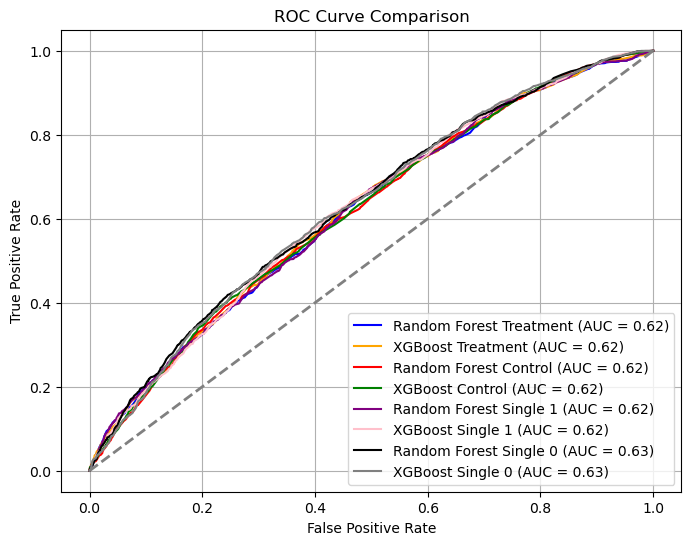

In [37]:
models = {
    "Random Forest Treatment": (track_results["random_forest_treatment"][1], "blue"),
    "XGBoost Treatment":       (track_results["xgboost_treatment"][1], "orange"),
    "Random Forest Control":   (track_results["random_forest_control"][1], "red"),
    "XGBoost Control":         (track_results["xgboost_control"][1], "green"),
    "Random Forest Single 1":  (safe_proba(track_results["random_forest_single"], X_test_single_1, len(X_test_single_1)), "purple"),
    "XGBoost Single 1":        (safe_proba(track_results["xgboost_single"],       X_test_single_1, len(X_test_single_1)), "pink"),
    "Random Forest Single 0":  (safe_proba(track_results["random_forest_single"], X_test_single_0, len(X_test_single_0)), "black"),
    "XGBoost Single 0":        (safe_proba(track_results["xgboost_single"],       X_test_single_0, len(X_test_single_0)), "grey"),
}

plt.figure(figsize=(8, 6))
for label, (y_pred, color) in models.items():
    fpr, tpr, auc_score = safe_roc(y_test, y_pred)
    plt.plot(fpr, tpr, label=f"{label} (AUC = {auc_score:.2f})", color=color)

plt.plot([0, 1], [0, 1], "--", color="gray", linewidth=2)
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

### 9. Plot Qini Curve and Evaluate uplift effect

Two_model Approach and Single-Model Approach Comparison

In [38]:
# Create result dataframe
results_df = pd.DataFrame({
    'y_true': y_test,
    'treatment': t_test,
    'uplift_tm_rf': track_results['uplift_random_forest_two_model'],
    'uplift_tm_xg': track_results['uplift_xgboost_two_model'],
    'uplift_sm_rf': track_results['uplift_random_forest_single_model'],
    'uplift_sm_xg': track_results['uplift_xgboost_single_model']

})
results_df.head()

,y_true,treatment,uplift_tm_rf,uplift_tm_xg,uplift_sm_rf,uplift_sm_xg
493,0,0,0.015867,0.055729,0.037558,0.046320
21569,0,1,0.063462,0.059345,0.044320,0.043350
3531,0,0,0.064583,0.080287,0.050231,0.053826
50370,1,1,0.113041,0.100874,0.116440,0.101927
38375,0,1,0.127797,0.132218,0.093452,0.124752


Join result with user feature

In [39]:
# same index with result df
X_test = X_test.reset_index(drop=True)

results_with_features = results_df.join(X_test)

results_with_features.head()

,y_true,treatment,uplift_tm_rf,uplift_tm_xg,uplift_sm_rf,uplift_sm_xg,mens,womens,newbie,zip_code_Surburban,...,recency_bins_low,recency_bins_medium,history_bins_low,history_bins_medium,zip_code_Urban_treatment,channel_Phone_treatment,history_bins_medium_treatment,recency_bins_low_treatment,newbie_mens,newbie_womens
493,0,0,0.015867,0.055729,0.037558,0.046320,1.0,1.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
21569,0,1,0.063462,0.059345,0.044320,0.043350,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3531,0,0,0.064583,0.080287,0.050231,0.053826,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
50370,1,1,0.113041,0.100874,0.116440,0.101927,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38375,0,1,0.127797,0.132218,0.093452,0.124752,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
# Find top 100 user
top_uplift_users = results_with_features.sort_values(by='uplift_tm_rf', ascending=False).head(100)
top_uplift_users


,y_true,treatment,uplift_tm_rf,uplift_tm_xg,uplift_sm_rf,uplift_sm_xg,mens,womens,newbie,zip_code_Surburban,...,recency_bins_low,recency_bins_medium,history_bins_low,history_bins_medium,zip_code_Urban_treatment,channel_Phone_treatment,history_bins_medium_treatment,recency_bins_low_treatment,newbie_mens,newbie_womens
22507,1,1,0.210504,0.163049,0.139061,0.187256,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19352,0,1,0.210504,0.163049,0.139061,0.187256,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18367,1,1,0.210504,0.163049,0.139061,0.187256,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26642,0,1,0.210504,0.163049,0.139061,0.187256,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50342,1,1,0.210504,0.163049,0.139061,0.187256,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14422,0,1,0.161097,0.130388,0.125182,0.146563,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43694,1,1,0.161097,0.130388,0.125182,0.146563,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54077,0,1,0.161097,0.130388,0.125182,0.146563,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58099,0,1,0.161097,0.130388,0.125182,0.146563,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Small sample size calculation: used qick comparison

In [41]:
# Calculate Qini Curve
def calculate_qini_curve(y_true, treatment, uplift_scores, n_groups=200):
    ''' 
    calculate_qini_curve: calclulate qini score and return AUUC

    input:
    - y_true: np.array, the true target variable (visit 0/1) 
    - treatment: np.array, whether to receive treatment (0/1)
    - uplift_scores: np.array, model predict uplift scores for each user
    - n_groups: int, which are used to divide qini curve into the number of groups (like percentile 1% people to 100% people)

    output:
    - qini_score: float, Qini Score (AUUC)
    - gains: list, each groups uplift (size = 100)
    - population_fractions: list, each groups percentile
    '''
    # Sort by uplift_score (predicted score)
    indices = np.argsort(uplift_scores)[::-1] # Sort by descending order
    y_true, treatment = y_true[indices], treatment[indices]

    # Boolean value: control group vs treatment group
    treated_mask, control_mask = treatment == 1, treatment == 0

    # Store gains and population fraction
    gains, population_fractions = [], []
    n_samples = len(y_true)

    for i in range(1, n_groups+1):
        n_samples_i = int(n_samples * i / n_groups)

        # Retrieve the treatment and control groups from the first n_samples_i samples
        treated_outcomes = y_true[:n_samples_i][treated_mask[:n_samples_i]]
        control_outcomes = y_true[:n_samples_i][control_mask[:n_samples_i]]

        # Calculate sample size for treatment group and control group
        n_treated, n_control = treated_mask[:n_samples_i].sum(), control_mask[:n_samples_i].sum()

        # Calculate uplift (treatment group target - control group target)
        treat_rate = treated_outcomes.mean() if n_treated > 0 else 0
        ctrl_rate = control_outcomes.mean() if n_control > 0 else 0
        uplift = treat_rate - ctrl_rate
        uplift = max(uplift, 0)  # avoid negative uplift


        gains.append(uplift)
        population_fractions.append(i / n_groups)
    
    # Calculate Qini-Score AUUC (Area Under Qini Curce)
    smooth_window = 10
    gains= pd.Series(gains).rolling(smooth_window, min_periods=1).mean().tolist()
    qini_score = np.trapz(gains, population_fractions)

    return qini_score, gains, population_fractions


In [42]:
qini_tm_rf, gains_tm_rf, fractions_tm_rf = calculate_qini_curve(
    results_df['y_true'].values,
    results_df['treatment'].values,
    results_df['uplift_tm_rf'].values
)
qini_tm_xg, gains_tm_xg, fractions_tm_xg = calculate_qini_curve(
    results_df['y_true'].values,
    results_df['treatment'].values,
    results_df['uplift_tm_xg'].values
)
qini_sm_rf, gains_sm_rf, fractions_sm_rf = calculate_qini_curve(
    results_df['y_true'].values,
    results_df['treatment'].values,
    results_df['uplift_sm_rf'].values
)
qini_sm_xg, gains_sm_xg, fractions_sm_xg = calculate_qini_curve(
    results_df['y_true'].values,
    results_df['treatment'].values,
    results_df['uplift_sm_xg'].values
)

print(f"Qini Score TM RF: {qini_tm_rf:.4f}")
print(f"Qini Score TM XG: {qini_tm_xg:.4f}")
print(f"Qini Score SM RF: {qini_sm_rf:.4f}")
print(f"Qini Score SM XG: {qini_sm_xg:.4f}")


Qini Score TM RF: 0.1032
Qini Score TM XG: 0.0941
Qini Score SM RF: 0.0994
Qini Score SM XG: 0.0727


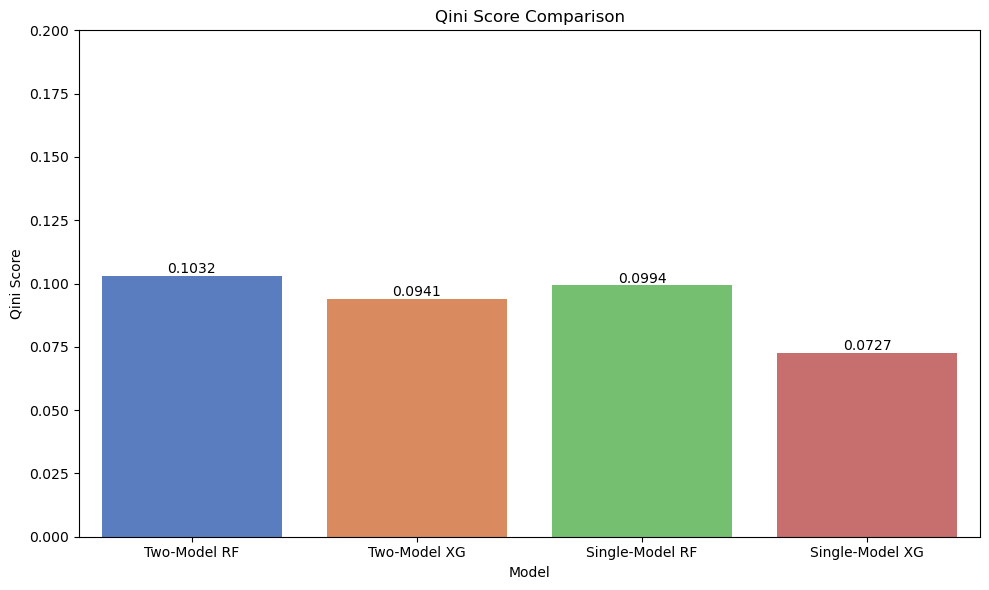

In [43]:
# Create dataframe for qini-score
auuc_df = pd.DataFrame({
    'Model': ['Two-Model RF', 'Two-Model XG', 'Single-Model RF', 'Single-Model XG'],
    'Qini Score': [qini_tm_rf, qini_tm_xg, qini_sm_rf, qini_sm_xg]
})

# Plot qini score bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Qini Score', data=auuc_df, palette='muted', hue='Model')
plt.xlabel('Model')
plt.ylabel('Qini Score')
plt.title('Qini Score Comparison')
plt.ylim(0, 0.20) 

for index, value in enumerate(auuc_df['Qini Score']):
    plt.text(index, value + 0.001, f'{value:.4f}', ha='center')

plt.tight_layout()
plt.show()

**Note**: Uplift Scores is predicted score by models, Qini score is calculated by real data (real uplift score)

In [44]:
# # Evaluate Qini For models
# def evaluate_qini_for_models(results_df):
#     ''' 
#     evaluate_qini_for_models: calculate all model qini_score 

#     input: 
#     - results_df: pd.DataFrame, contains y_true, treatment, predicted uplift_scores for each model

#     output:
#     - qini_df: pd.DataFrame, contains all model name and their qini score
#     - gains_dict: dict, contains all model gains
#     - population_fractions_dict: dict, contains all model population_fractions
#     '''
#     model_columns = {
#         'Two-Model RF': 'uplift_tm_rf',
#         'Two-Model XGBoost': 'uplift_tm_xg',
#         'S-Learner RF': 'uplift_sm_rf',
#         'S-Learner XGBoost': 'uplift_sm_xg'
#     }

#     qini_scores, gains_dict, fractions_dict = {}, {}, {}

#     for model_name, uplift_col in model_columns.items():
#         qini_score, gains, fractions = calculate_qini_curve(
#             results_df['y_true'].values, 
#             results_df['treatment'].values, 
#             results_df[uplift_col].values
#         )
#         qini_scores[model_name] = qini_score
#         gains_dict[model_name] = gains
#         fractions_dict[model_name] = fractions

#     qini_df = pd.DataFrame(list(qini_scores.items()), columns=['Model', 'Qini Score'])
    
#     return qini_df, gains_dict, fractions_dict

In [45]:
# def plot_qini_curve(gains_dict, fractions_dict):
#     """
#     plot qini curve

#     input: 
#     - gains_dict: dict, contains all model gains
#     - fractions_dict: dict, contains all model population_fractions
#     """
#     plt.figure(figsize=(10, 6))
#     sns.set_style("whitegrid")

#     for model, gains in gains_dict.items():
#         plt.plot(fractions_dict[model], gains, label=model)

#     plt.xlabel("Proportion Targeted", fontsize=14)
#     plt.ylabel("Uplift", fontsize=14)
#     plt.title("Qini Curves for Multiple Models", fontsize=16)
#     plt.legend(fontsize=12)
#     plt.show()


In [46]:
# # Plot qini curve for each model
# qini_df, gains_dict, fractions_dict = evaluate_qini_for_models(results_df)

# print(qini_df)

# plot_qini_curve(gains_dict, fractions_dict)

#### Large sample size calculation

##### Step1 Compute target class

In [47]:
def compute_target_class(df):
    ''' 
    compute_target_class: label data and divide into four groups of data
    - Baseline: y_true = 0, Treatment = 0 
    - Treatment group success: y_true = 1, Treatment = 1
    - Treatment group fail: y_true = 0, Treatment = 1
    - Control group success: y_true = 1, Treatment = 0

    input: df

    output: classfify group df

    '''
    df = df.copy()
    df['target_class'] = 0  # Baseline group
    df.loc[(df['treatment'] == 0) & (df['y_true'] == 1), 'target_class'] = 1
    df.loc[(df['treatment'] == 1) & (df['y_true'] == 0), 'target_class'] = 2
    df.loc[(df['treatment'] == 1) & (df['y_true'] == 1), 'target_class'] = 3
    return df

##### Step 2 Rank user by uplift_score

In [48]:
def qini_rank(df, uplift_score):
    """
    qini_rank: Rank user by uplidt_score
    df: pd.DataFrame, contains target_class and  uplift_score
    uplift_score: Obtained by models
    """
    ranked = df[['target_class', uplift_score]].rename(columns={uplift_score: 'uplift_score'}).copy()
    ranked['n'] = ranked['uplift_score'].rank(pct=True, ascending=False) # Sort by descending order
    return ranked.sort_values(by='n').reset_index(drop=True)

##### Step 3 Calculate Qini Gain

In [49]:
def qini_eval(ranked):
    """
    Calculate qini curve by ranked data
    """
    C = sum(ranked['target_class'] <= 1)  # Control group
    T = sum(ranked['target_class'] >= 2)  # Treatment group

    # initialize gain
    ranked['cr'] = (ranked['target_class'] == 1).astype(int)  # # of Control group visit
    ranked['tr'] = (ranked['target_class'] == 3).astype(int)  # # of Treatment group visit

    ranked['cr/c'] = ranked['cr'].cumsum() / C
    ranked['tr/t'] = ranked['tr'].cumsum() / T

    # Calclulate Qini Uplift 
    ranked['uplift'] = ranked['tr/t'] - ranked['cr/c']

    # Calculate Random model
    random_model = ranked[['n', 'uplift']].copy()
    random_model['uplift'] = random_model['n'] * ranked['uplift'].iloc[-1]
    random_model['model'] = 'Random model'

    # Add point(0,0)
    q0 = pd.DataFrame({'n': [0], 'uplift': [0]})
    ranked = pd.concat([q0, ranked]).reset_index(drop=True)
    random_model = pd.concat([q0, random_model]).reset_index(drop=True)

    # Merge result
    ranked['model'] = 'Uplift model'
    return pd.concat([ranked, random_model]).reset_index(drop=True)

##### Step 4: Qini visualization

In [50]:
def qini_plot(merged_results):
    """
    Plot Qini Curve
    """
    sns.set_style('whitegrid')
    plt.figure(figsize=(10, 6))
    
    sns.lineplot(x='n', y='uplift', hue='model', data=merged_results, style='model', palette='Set2')

    plt.xlabel('Proportion Targeted', fontsize=14)
    plt.ylabel('Uplift', fontsize=14)
    plt.title('Qini Curves for Multiple Models', fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

##### Step 5: Calculate all model Qini

In [ ]:
def compute_qini_for_models(df, uplift_columns, model_names):
    """
    calculate and plot all models gini curve
    """
    df = compute_target_class(df)  # calculate target_class
    merged_results = pd.DataFrame()

    for uplift_score, model_name in zip(uplift_columns, model_names):
        ranked = qini_rank(df, uplift_score)
        merged = qini_eval(ranked)
        merged['model'] = model_name
        merged_results = pd.concat([merged_results, merged], ignore_index=True)

    qini_plot(merged_results)
    return merged_results

##### Step 6 Run Qini Calculation

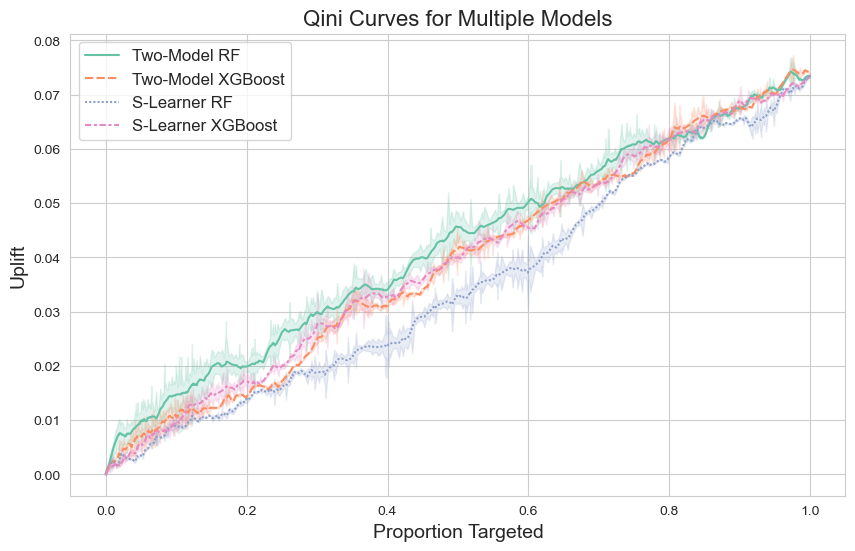

In [52]:
uplift_columns = ['uplift_tm_rf', 'uplift_tm_xg', 'uplift_sm_rf', 'uplift_sm_xg']
model_names = ['Two-Model RF', 'Two-Model XGBoost', 'S-Learner RF', 'S-Learner XGBoost']

# Plot Gini curve
qini_results = compute_qini_for_models(results_df, uplift_columns, model_names)


#### 10. Identify target customers

Select each model top 20% qini score user 

In [53]:
df_qini_result = qini_results.copy()
df_qini_result = df_qini_result.dropna(subset=["uplift_score"])
df_qini_result = df_qini_result.sort_values(by="uplift_score", ascending=False)
top_20_percent = df_qini_result.groupby("model").apply(lambda x: x.head(int(len(x) * 0.2))).reset_index(drop=True)


top_20_percent

,n,uplift,target_class,uplift_score,cr,tr,cr/c,tr/t,model
0,0.000078,0.000000,2.0,0.145865,0.0,0.0,0.000000,0.000000,S-Learner RF
1,0.000352,0.000000,2.0,0.142189,0.0,0.0,0.000000,0.000000,S-Learner RF
2,0.000352,0.000158,3.0,0.142189,0.0,1.0,0.000000,0.000158,S-Learner RF
3,0.000352,0.000158,2.0,0.142189,0.0,0.0,0.000000,0.000158,S-Learner RF
4,0.000352,0.000315,3.0,0.142189,0.0,1.0,0.000000,0.000315,S-Learner RF
...,...,...,...,...,...,...,...,...,...
10219,0.199468,0.014060,3.0,0.091700,0.0,1.0,0.034167,0.048227,Two-Model XGBoost
10220,0.199468,0.014060,2.0,0.091700,0.0,0.0,0.034167,0.048227,Two-Model XGBoost
10221,0.199468,0.014060,2.0,0.091700,0.0,0.0,0.034167,0.048227,Two-Model XGBoost
10222,0.199468,0.014060,2.0,0.091700,0.0,0.0,0.034167,0.048227,Two-Model XGBoost


Precision Marketing: The marketing team can send optimal discounts or push advertisements to these users.